- get rain data and visualise for overview <font color='orange'>&#9728;</font>
- cut and split data to reasonable train, val, test sets <font color='orange'>&#9728;</font>
- set up first generator and discriminator and overfit, play around with it, get first results (_November/December_)
- train on small training set and improve losses, accuracy, results (_December_)
- experiment with temporal discriminator (_December/January_)
- experiment with wind data (_January_)

## Imports and settings

In [1]:
import src

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data/rx')

In [78]:
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

In [106]:
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization, TimeDistributed, LSTM
from keras.optimizers import Adam, RMSprop
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8528138879429290159
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1945332057894055086
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [107]:
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" for CPU

______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.

In [ ]:
sys.path[0]

In [3]:
files = os.listdir("../data/rx")
total_length = len(files)
inputs = np.zeros((total_length,900,900))

In [4]:

for i, file in enumerate(files):
    if i%10 == 0:
        print(i, end=", ")
    with open(sys.path[0] + '/' + file, "rb") as f:
        byte = f.read()
        start = 0
        for j in range(len(byte)) :
            if byte[j] == 62 :
                start = j
                break
        inputs[i] = np.flip(np.reshape(np.asarray([c for c in byte[start+3:]]),(900,900)), axis=0)
        inputs[i][inputs[i] == 250] = -1

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 

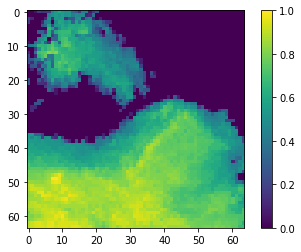

In [140]:
plt.imshow(inputs[0][500:564,600:664]/inputs[0][500:564,600:664].max())
plt.colorbar()
plt.savefig("2.png")

In [72]:
images = src.generate_datasets(inputs, n=10000, size=64, length=2, normalize=True, split=(6,2,2))

Shape of data: (10000, 2, 64, 64)

Training set: (6000, 2, 64, 64)
Validation set: (2000, 2, 64, 64)
Test set: (2000, 2, 64, 64)


In [95]:
images = np.load(sys.path[0]+"/5_minute.npy").item()

In [103]:
#low_res_train = images["low_res_train"]
#low_res_xval = images["low_res_xval"]
#low_res_test = images["low_res_test"]
#overfit = np.reshape(images['images'],np.shape(images['images'])+(1,))
train = np.reshape(images["train"],np.shape(images["train"])+(1,))
xval = np.reshape(images["xval"],np.shape(images["xval"])+(1,))
test = np.reshape(images["test"],np.shape(images["test"])+(1,))
print(f"Training data: {train.shape}\nValidation data: {xval.shape}\nTest data: {test.shape}")

Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)


In [104]:
lstm_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],1,)+train.shape[2:]))
lstm_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],1,)+train.shape[2:]))
lstm_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],1,)+xval.shape[2:]))
lstm_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],1,)+xval.shape[2:]))
print(lstm_train.shape,"\n",lstm_truth.shape,"\n",lstm_val.shape,"\n",lstm_val_truth.shape)
lstm_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],1,)+test.shape[2:]))
lstm_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],1,)+test.shape[2:]))

(6000, 1, 64, 64, 1) 
 (6000, 1, 64, 64, 1) 
 (2000, 1, 64, 64, 1) 
 (2000, 1, 64, 64, 1)


In [ ]:
overfit_train = np.reshape(train[5,0,:,:,:],((1,1,)+train.shape[2:]))
overfit_truth = np.reshape(train[5,1,:,:,:],((1,1,)+train.shape[2:]))

In [ ]:
%matplotlib inline
src.visualise_data(xval[:,:,:,:,0])

## LSTM generator

In [142]:
#batch_size=10
lstm_model = keras.Sequential()
# define CNN model
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=8, kernel_size=5, strides=2, padding='same'))) #8
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation("relu"))

lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=16, kernel_size=5, strides=2, padding='same')))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation("relu"))

lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=32, kernel_size=5, strides=2, padding='same')))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation("relu"))

lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=64, kernel_size=5, strides=2, padding='same')))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation("relu"))

lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(
    filters=128, kernel_size=5, strides=4, padding='same', activation='tanh')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))

#LSTM
lstm_model.add(keras.layers.LSTM(units=128, return_sequences=True))

#upconv
lstm_model.add(keras.layers.Reshape((1,1,1,128)))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=64,kernel_size=5,strides=4,padding='same', activation='relu'))) #64
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=32,kernel_size=5,strides=2,padding='same', activation='relu')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=16,kernel_size=5,strides=2,padding='same', activation='relu')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=8,kernel_size=5,strides=2,padding='same', activation='relu')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv2DTranspose(
    filters=1,kernel_size=5,strides=2,padding='same', activation='relu')))

lstm_model.build((None,1,)+train.shape[2:])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, 1, 32, 32, 8)      208       
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 32, 32, 8)      32        
_________________________________________________________________
activation_2 (Activation)    (None, 1, 32, 32, 8)      0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 1, 16, 16, 16)     3216      
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 16, 16, 16)     64        
_________________________________________________________________
activation_3 (Activation)    (None, 1, 16, 16, 16)     0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 1, 8, 8, 32)       12832     
__________

In [109]:
callback = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
            keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [143]:
def custom_loss(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred) + src.gradient_diff(y_true, y_pred)

In [ ]:
lstm_model.load_weights("best_model.h5")

In [144]:
lstm_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss=custom_loss, metrics=[src.relative_error_tensor]) 

Tensor("metrics_1/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("time_distributed_33_target:0", shape=(?, ?, ?, ?, ?), dtype=float32)


In [145]:
#train the model
lstm_model.fit(lstm_train, lstm_truth,
               validation_data=(lstm_val, lstm_val_truth),
               batch_size = 100,
               epochs=50,
               callbacks=callback,
               shuffle = True)

Train on 6000 samples, validate on 2000 samples
Epoch 1/50
6000/6000 [==============================] - 15s 2ms/step - loss: 0.2869 - relative_error_tensor: 0.9874 - val_loss: 0.2738 - val_relative_error_tensor: 0.9742
Epoch 2/50
6000/6000 [==============================] - 10s 2ms/step - loss: 0.2476 - relative_error_tensor: 0.8565 - val_loss: 0.2378 - val_relative_error_tensor: 0.8984
Epoch 3/50
6000/6000 [==============================] - 10s 2ms/step - loss: 0.2104 - relative_error_tensor: 0.7302 - val_loss: 0.2037 - val_relative_error_tensor: 0.8150
Epoch 4/50
6000/6000 [==============================] - 10s 2ms/step - loss: 0.1558 - relative_error_tensor: 0.6303 - val_loss: 0.1387 - val_relative_error_tensor: 0.7260
Epoch 5/50
6000/6000 [==============================] - 10s 2ms/step - loss: 0.1215 - relative_error_tensor: 0.5661 - val_loss: 0.1213 - val_relative_error_tensor: 0.6231
Epoch 6/50
6000/6000 [==============================] - 10s 2ms/step - loss: 0.1154 - relative_er

Epoch 32/50
6000/6000 [==============================] - 25s 4ms/step - loss: 0.0875 - relative_error_tensor: 0.3878 - val_loss: 0.0882 - val_relative_error_tensor: 0.3963
Epoch 33/50
6000/6000 [==============================] - 26s 4ms/step - loss: 0.0872 - relative_error_tensor: 0.3866 - val_loss: 0.0877 - val_relative_error_tensor: 0.3926
Epoch 34/50
6000/6000 [==============================] - 25s 4ms/step - loss: 0.0867 - relative_error_tensor: 0.3826 - val_loss: 0.0873 - val_relative_error_tensor: 0.3903
Epoch 35/50
6000/6000 [==============================] - 23s 4ms/step - loss: 0.0865 - relative_error_tensor: 0.3816 - val_loss: 0.0870 - val_relative_error_tensor: 0.3886
Epoch 36/50
6000/6000 [==============================] - 23s 4ms/step - loss: 0.0861 - relative_error_tensor: 0.3782 - val_loss: 0.0869 - val_relative_error_tensor: 0.3872
Epoch 37/50
6000/6000 [==============================] - 26s 4ms/step - loss: 0.0860 - relative_error_tensor: 0.3786 - val_loss: 0.0868 - va

Epoch 49/50
6000/6000 [==============================] - 26s 4ms/step - loss: 0.0831 - relative_error_tensor: 0.3595 - val_loss: 0.0853 - val_relative_error_tensor: 0.3795
Epoch 50/50
6000/6000 [==============================] - 29s 5ms/step - loss: 0.0830 - relative_error_tensor: 0.3581 - val_loss: 0.0843 - val_relative_error_tensor: 0.3699


In [146]:
hist = lstm_model.history
hist.history.keys()

dict_keys(['val_loss', 'val_relative_error_tensor', 'loss', 'relative_error_tensor'])

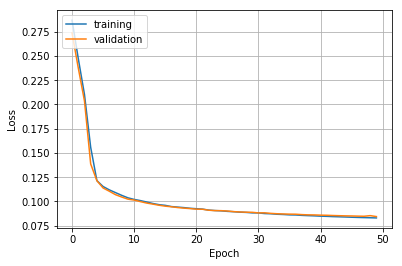

In [147]:
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training.png')

In [148]:
#test
predictions = lstm_model.predict(lstm_test, batch_size=50)
truth       = lstm_test_truth
truth.shape

(2000, 1, 64, 64, 1)

In [149]:
args = src.arg_getter(truth, predictions)
args[:10]

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:198: RuntimeWarning: divide by zero encountered in true_divide
  images[i, :, :, :] = np.divide(num, den)


[697, 1327, 1542, 1999, 1429, 1879, 1283, 909, 1638, 1640]

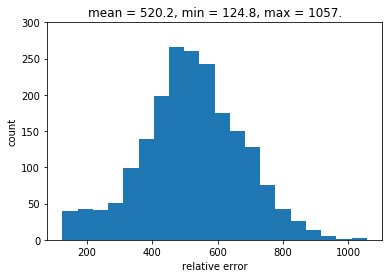

In [150]:
error_images, error_vals, error_means = error_distribution(truth,predictions, metric="difference")

In [128]:
def error_distribution(truth, predictions, nbins=20, metric="difference"):
    """
    plot relative error dist. of results
    :param truth: ground truth
    :param predictions: predictions of network
    :param metric: difference or relative_error
    :return: nothing (plots relative error distributions)
    """

    if metric == "relative_error":
        error_images, error_vals, error_means = src.relative_error(truth, predictions)
    elif metric == "difference":
        error_images, error_vals, error_means = src.difference(truth, predictions)
    else:
        sys.exit("Metric must be 'difference' or 'relative_error'.")

    plt.hist(error_vals, nbins)
    plt.xlabel('relative error')
    plt.ylabel('count')
    plt.title('mean = ' + str(np.mean(error_vals))[0:5] + ', min = ' + str(np.min(error_vals))[0:5] + ', max = ' + str(
        np.max(error_vals))[0:5])
    plt.yticks(list(set([int(tick) for tick in plt.yticks()[0]])))
    plt.savefig(f"{metric}.png")
    plt.show()
    return error_images, error_vals, error_means

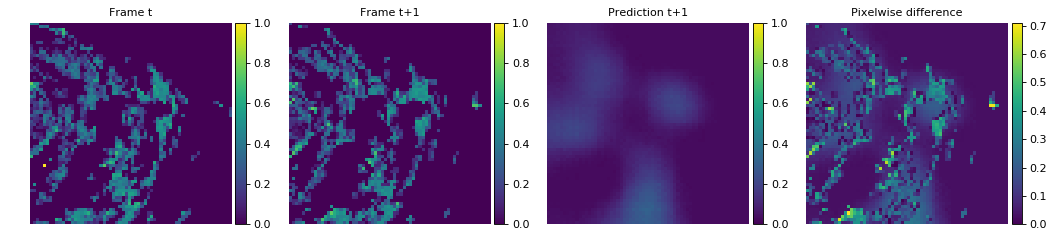

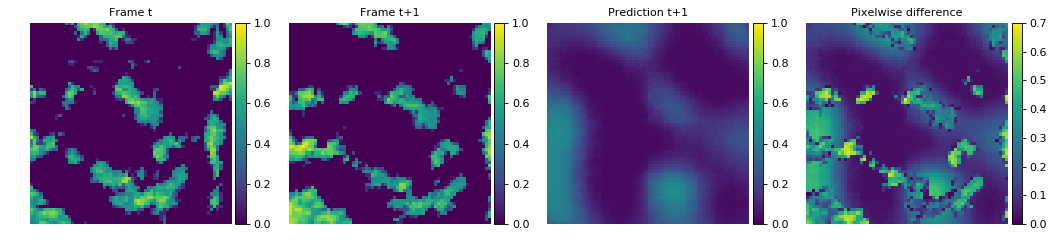

In [153]:
src.result_plotter(args[-2:], (lstm_test[:,:,:,:,0], truth[:,:,:,:,0], predictions[:,:,:,:,0], error_images[:,:,:,:,0]))

## Discriminator

In [ ]:
D = keras.Sequential()
depth = 2
dropout = 0.4

conv1 = keras.layers.Conv2D(filters=depth*1 ,kernel_size=10, strides=5, input_shape=(900,900,1), padding='same')
relu1 = keras.layers.LeakyReLU(alpha=0.2)
dropout1 = keras.layers.Dropout(dropout)

conv2 = keras.layers.Conv2D(filters=depth*2, kernel_size=10, strides=5, padding='same')
relu2 = keras.layers.LeakyReLU(alpha=0.2)
dropout2 = keras.layers.Dropout(dropout)

conv3 = keras.layers.Conv2D(filters=depth*4, kernel_size=6, strides=2, padding='same')
relu3 = keras.layers.LeakyReLU(alpha=0.2)
dropout3 = keras.layers.Dropout(dropout)

conv4 = keras.layers.Conv2D(filters=depth*8, kernel_size=2, strides=2, padding='same')
relu4 = keras.layers.LeakyReLU(alpha=0.2)
dropout4 = keras.layers.Dropout(dropout)

# Out: 1-dim probability
flatten = keras.layers.Flatten()
fcl1 = keras.layers.Dense(1)
sig1 = keras.layers.Activation('sigmoid')
#summary()
D.add(conv1)
D.add(relu1)
D.add(dropout1)
D.add(conv2)
D.add(relu2)
D.add(dropout2)
D.add(conv3)
D.add(relu3)
D.add(dropout3)
D.add(conv4)
D.add(relu4)
D.add(dropout4)
D.add(flatten)
D.add(fcl1)
D.add(sig1)
D.summary()

In [ ]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=3e-8)
AM = keras.Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
AM.fit(train_val_inputs,
          train_val_targets,
          batch_size = 50,
          epochs=50,
          validation_split = 0.1,
          shuffle = True)

In [ ]:
a = train[0,0,:,:,0]
b = train[0,1,:,:,0]

In [ ]:
b.shape

In [ ]:
((a-b)**2).mean()

In [ ]:
((a-b)**2).sum()/64/64

In [ ]:
f = np.sum(np.abs(np.abs(a[1:,:]-a[:-1,:])-np.abs(b[1:,:]-b[:-1,:])))+np.sum(np.abs(np.abs(a[:,1:]-a[:,:-1])-np.abs(b[:,1:]-b[:,:-1])))

In [ ]:
f/64/63/2-summe/(len(bb)+len(aa))

In [ ]:
aa = np.abs(np.abs(a[1:,:]-a[:-1,:])-np.abs(b[1:,:]-b[:-1,:])).flatten()
bb = np.abs(np.abs(a[:,1:]-a[:,:-1])-np.abs(b[:,1:]-b[:,:-1])).flatten()
summe = np.sum(aa+bb)/(len(bb)+len(aa))
summe

In [ ]:
aa.shape

In [ ]:
summe = np.sum(aa+bb)
summe

In [ ]:
summe/(len(bb)+len(aa))

In [ ]:
import keras.backend as K

In [ ]:
yTrue = K.variable(a.reshape(1,1,64,64,1))
yPred =  K.variable(b.reshape(1,1,64,64,1))
alpha = 1

In [ ]:
true = K.pow(K.flatten(K.abs(K.abs(yTrue[:,:,1:,:,:] - yTrue[:,:,:-1,:,:]) -
                                 K.abs(yPred[:,:,1:,:,:] - yPred[:,:,:-1,:,:]))),alpha)
pred = K.pow(K.flatten(K.abs(K.abs(yTrue[:,:,:,1:,:] - yTrue[:,:,:,:-1,:]) -
                                 K.abs(yPred[:,:,:,1:,:] - yPred[:,:,:,:-1,:]))),alpha)

In [ ]:
vv = (K.eval(K.sum(true))+K.eval(K.sum(pred))) / tf.to_float(K.shape(true)[0] + K.shape(pred)[0])

In [ ]:
K.eval(vv)

In [ ]:
K.int_shape(true)[0]

In [ ]:
K.count_params(true)

In [ ]:
K.eval(K.shape(vv))